In [20]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import icecream as ic

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import wandb
from PIL import Image

from dataset import DatasetCelebA_Sketch

import cv2
import pandas as pd
import torchvision.transforms as transforms


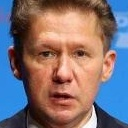

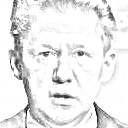

[1 0 0 0]


In [28]:
EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium_2.xlsx"
DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"
SKETCH_DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Sketch_Crop_medium\\"

resize =  transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize([128,128])])

transf = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize([128,128]),
                            transforms.ToTensor()])

transf_sketch = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.Resize([128,128]),
                            transforms.ToTensor()
                            ])

df = pd.read_excel(EXCEL_PATH)
data = df["image_id"]
labels = df.iloc[:, 1:(4 + 1)]
index = 31

# 25 - nice female
# 31 - male

base_path = DATASET_PATH
img = cv2.imread(DATASET_PATH + data[index])
# img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\source\\lena.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sketch_img = cv2.imread(SKETCH_DATASET_PATH + data[index])
# sketch_img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\destination\\lena.jpg')
sketch_img = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB)

batch_data = img
batch_data = transf(batch_data)

batch_sketch_data = sketch_img
batch_sketch_data = transf_sketch(batch_sketch_data)

batch_labels = labels.iloc[index].values

pil_img = resize(img)
pil_img_sketch = resize(sketch_img)
display(pil_img)
display(pil_img_sketch)
print(batch_labels)


In [37]:
from CVAE_Encoder import Encoder
from CVAE_Decoder import Decoder
ATTR_DIM = 4

encoder = Encoder(attribute_number=ATTR_DIM)
decoder = Decoder(attribute_number=ATTR_DIM)
encoder.cuda()
decoder.cuda()

encoder.eval()
decoder.eval()

decoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage1_Attr2Sketch\checkpoints\cropface_10epoci\\retea_Decoder.pt'))
encoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage1_Attr2Sketch\checkpoints\cropface_10epoci\\retea_Encoder.pt'))

def print_images(attr, display=0):
    esantioane_proba = torch.stack([batch_sketch_data], dim=0)
    etichete_proba = torch.FloatTensor([attr])
    # etichete_proba = torch.FloatTensor([[1,1,1,1]])

    print(esantioane_proba.shape)
    DEVICE = 'cuda'
    esantioane_proba = esantioane_proba.to(torch.device(DEVICE))
    etichete_proba = etichete_proba.to(torch.device(DEVICE))
    zgomot_proba = torch.FloatTensor(esantioane_proba.shape[0], 256).normal_(0, 1)
    # print(zgomot_proba)
    zgomot_proba  = zgomot_proba.to(torch.device(DEVICE))

    zgomot_embedded, schita_embedded, encode_text = encoder(noise=zgomot_proba, attr_text=etichete_proba, sketch=esantioane_proba, detach_flag=True)
    reconstructed_sketch_images, reconstructed_fake_images = decoder(zgomot_embedded[0], schita_embedded[0], detach_flag=True)

    # print(encode_text)

    reconstructed_sketch_images = torch.squeeze(reconstructed_sketch_images, 0)
    reconstructed_sketch_images = reconstructed_sketch_images.to(torch.device('cpu'))

    reconstructed_fake_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_fake_images = reconstructed_fake_images.to(torch.device('cpu'))

    if display == 1:
        plt.subplot(1, 4, 1)
        imshow(np.asarray(pil_img))
        plt.subplot(1, 4, 2)
        imshow(np.asarray(pil_img_sketch))
        plt.subplot(1, 4, 3)
        plt.imshow(np.transpose(reconstructed_sketch_images,(1,2,0)), cmap='gray')
        plt.subplot(1, 4, 4)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.show()

    sketch = np.transpose(reconstructed_sketch_images,(1,2,0))
    noise_img = np.transpose(reconstructed_fake_images,(1,2,0))

    return sketch, noise_img

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


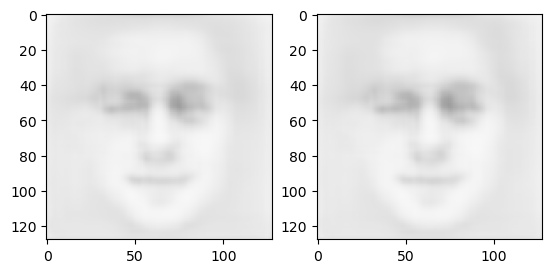

In [38]:
sketch_img1, fake_img1 = print_images([0,0,0,0])
sketch_img2, fake_img2 = print_images([1,1,1,1])

# male, smiling, eyeglasses, no beard

# sketch_diff = sketch_img1 - sketch_img2
# sketch_fake = fake_img1 - fake_img2


plt.subplot(1, 2, 1)
plt.imshow(fake_img1, cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(fake_img2, cmap = 'gray')
plt.show()
